# ResNet-50 for Cats.Vs.Dogs

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
from __future__ import division
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, merge, Input, Lambda, Reshape
from keras.utils import np_utils
from keras import backend as K
from keras.preprocessing import image
from keras.optimizers import SGD, Nadam
from keras import layers
from keras.utils.data_utils import get_file

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import random
from collections import Counter

import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

Using TensorFlow backend.


In [3]:
SEED = 42
np.random.seed(SEED)

In [4]:
config = tf.ConfigProto()
from keras.backend.tensorflow_backend import set_session
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True 
set_session(tf.Session(config=config))

In [5]:
from utils import get_available_gpus
GPUs = get_available_gpus()
print(GPUs)

[u'/gpu:0']


In [6]:
DATA_DIR = '/home/Drive2/rishabh/'
TRAIN_FEATURES = os.path.join(DATA_DIR, 'features_train_vgg.npy')
TEST_FEATURES = os.path.join(DATA_DIR, 'bottleneck_features_vgg.npy')
CHECKPOINTED_WEIGHTS = os.path.join(DATA_DIR, 'checkpointed_weights_desk_vgg.hdf5')
INIT_WEIGHTS = os.path.join(DATA_DIR, 'init_weights_base_desk_vgg.hdf5')
MODEL_IMAGE = os.path.join(DATA_DIR, 'vgg16.png')

## Data preprocessing

- The images in train folder are divided into a training set and a validation set.
- The images both in training set and validation set are separately divided into two folders -- cat and dog according to their lables.

*(the two steps above were finished in  Preprocessing train dataset.ipynb)*

- The RGB color values of the images are rescaled to 0~1.
- The size of the images are resized to 224*224.


In [7]:
# from keras.applications.vgg16 import preprocess_input
# from keras.preprocessing import image

# def get_features(image_dir, model):
#     features = []
#     for img in image_dir:
#         img_path = img[0]
#         img = image.load_img(img_path, target_size=(224, 224))
#         x = image.img_to_array(img)
#         x = np.expand_dims(x, axis=0)
#         x = preprocess_input(x)
#         feature = model.predict(x)
#         feature = MaxPooling2D((7, 7), name='max_pool')(feature)
#         out = Flatten()(feature)
#         features.append(out)
#     return features
#         model = Model(inputs = base_model.input, outputs = flatten)

In [8]:
image_width = 224
image_height = 224
image_size = (image_width, image_height)
BATCH_SIZE = 2000

train_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
        'mytrain',  # this is the target directory
        target_size=image_size,  # all images will be resized to 224x224
        batch_size=BATCH_SIZE,
        class_mode='binary')

test_datagen = ImageDataGenerator()#rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
        'myvalid',  # this is the target directory
        target_size=image_size,  # all images will be resized to 224x224
        batch_size=BATCH_SIZE,
        class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [9]:
x, y = train_generator.next()

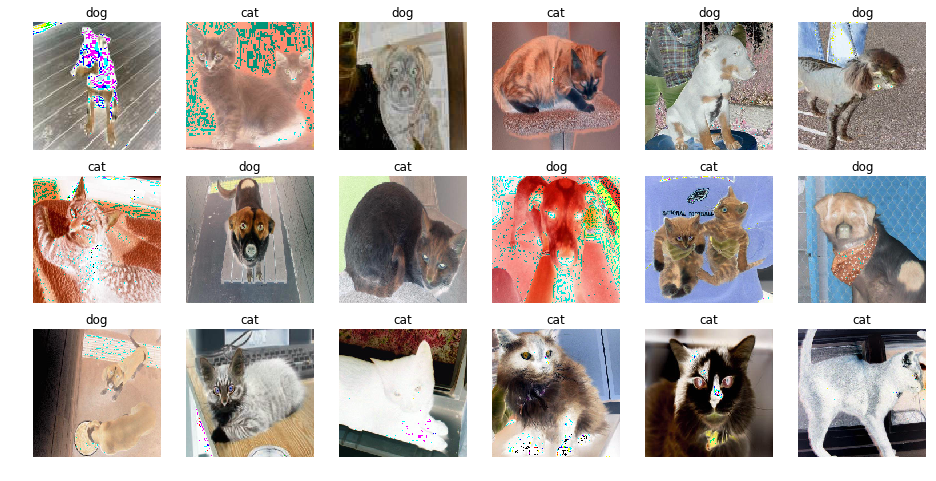

In [10]:
plt.figure(figsize=(16, 8))
for i, (img, label) in enumerate(zip(x, y)):
    if i >= 18:
        break
    plt.subplot(3, 6, i+1)
    if label == 1:
        plt.title('dog')
    else:
        plt.title('cat')
    plt.axis('off')
#     plt.imshow(img, interpolation="nearest")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# # Delete the dataset generated above
del x, y

In [12]:
X_train, y_train = train_generator.next()
X_test, y_test = test_generator.next()

In [13]:
len(X_train)

2000

## Build the structure of VGG16 for Cats.Vs.Dogs

1. Build the structure of VGG16without top layer.
2. Add top layer to VGG16
3. Setup training attribute.
4. Compile the model.

In [14]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

size = (image_width, image_height, 3)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=size)

In [15]:
from keras.utils import plot_model
if not os.path.exists(MODEL_IMAGE):
    plot_model(base_model, to_file=MODEL_IMAGE)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

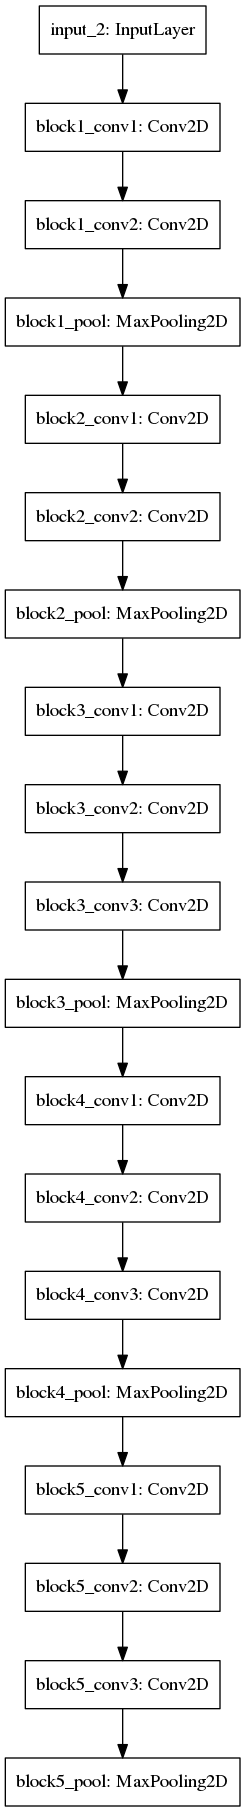

In [16]:
from IPython.display import Image
base_model.summary()
Image(filename=MODEL_IMAGE) 

### 1.Build the structure of VGG16 without top layer. 
Pass the train and test data throught the network and del the model from memory

In [17]:
from keras.layers.pooling import AveragePooling2D, MaxPooling2D
from keras.applications.vgg16 import preprocess_input


def create_train_test_features():
    with tf.device(GPUs[0]):
        x = base_model.output # .get_layer('activation_46')
        x = MaxPooling2D((7, 7), name='max_pool')(x)
        flatten = Flatten()(x)
        model = Model(inputs = base_model.input, outputs = flatten)

    # Train data
    
    bottleneck_features_train = model.predict(preprocess_input(X_train))
    # save the output as a Numpy array
    np.save(open(TRAIN_FEATURES, 'w'), bottleneck_features_train)

    # Test data
    bottleneck_features_test = model.predict(preprocess_input(X_test))
    # save the output as a Numpy array
    np.save(open(TEST_FEATURES, 'w'), bottleneck_features_test)
    del model
    
if not os.path.exists(TRAIN_FEATURES):
    create_train_test_features()
del base_model


### Build the Model

In [230]:
from keras.layers.advanced_activations import LeakyReLU
from keras.regularizers import l2, l1

def dense_relu_bn_dropout(x, size, dropout, alpha = 0.1, reg = 0):
    x = Dense(size, kernel_regularizer = l2(reg))(x)
    x = Activation('relu')(x)
#     LeakyReLU(alpha)(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout)(x)
    return x

def create_network(reg, dropout, alpha = 0.1):
    inputs = Input(shape=(2*INPUT_SHAPE,))
    x = dense_relu_bn_dropout(inputs, 256, dropout, reg)
#     x = dense_relu_bn_dropout(x, 256, dropout, reg)
    predictions = Dense(1, kernel_regularizer = l2(reg), activation='sigmoid')(x)
    base_network = Model(inputs=inputs, outputs = predictions)
    print(base_network.summary())
    return base_network

### DESK Net

In [231]:
INPUT_SHAPE = 512
with tf.device(GPUs[0]):
    input_a = Input(shape=(INPUT_SHAPE,))
    input_b = Input(shape=(INPUT_SHAPE,))
    concatenated = layers.concatenate([input_a, input_b])
    base_network = create_network(reg = 100, dropout = 0.6)
    processed = base_network(concatenated)
    desk_net = Model([input_a, input_b], processed)
desk_net.save_weights(INIT_WEIGHTS)
print(desk_net.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_76 (InputLayer)        (None, 1024)              0         
_________________________________________________________________
dense_58 (Dense)             (None, 256)               262400    
_________________________________________________________________
activation_9 (Activation)    (None, 256)               0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_34 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 257       
Total params: 263,681
Trainable params: 263,169
Non-trainable params: 512
_________________________________________________________________
No


## Train VGG16 for Cats.Vs.Dogs and Save the best model.

In [232]:
train_data = np.load(open(TRAIN_FEATURES, 'r'))

In [245]:
from utils import DataGenerator

NUM_TRAIN = 1500
NUM_TRAIN_PAIRS = 100000 #(NUM_TRAIN ** 2)//5
NUM_VAL_PAIRS = 20000
BATCH_SIZE = 256
datagen = DataGenerator(train_data, y_train, batch_sz = BATCH_SIZE, num_train_pairs = NUM_TRAIN_PAIRS,
                    num_train = NUM_TRAIN, num_val_pairs = NUM_VAL_PAIRS, verbose = True)

Counter({1.0: 50039, 0.0: 49961})
Counter({1.0: 10032, 0.0: 9968})


In [264]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5,
              patience=5, verbose = 1, min_lr=1e-8)
early_stopping = EarlyStopping(monitor='acc',
                              min_delta=1e-4,
                              patience=15,
                              verbose=0, mode='auto')
checkpointer = ModelCheckpoint(filepath=CHECKPOINTED_WEIGHTS, verbose=1, save_best_only=True, monitor='val_acc')

In [265]:
nadam = Nadam(lr=1e-4)
desk_net.compile(optimizer=nadam, loss='binary_crossentropy', metrics=['accuracy'])
desk_net.load_weights(INIT_WEIGHTS)

In [266]:
STEPS_PER_EPOCH = NUM_TRAIN_PAIRS//BATCH_SIZE
VALIDATION_STEPS = NUM_VAL_PAIRS//BATCH_SIZE
history = desk_net.fit_generator(
        datagen.next_train(),
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=500,
        validation_data=datagen.next_val(),
        validation_steps=VALIDATION_STEPS,
        callbacks = [reduce_lr, checkpointer, early_stopping])

Epoch 1/500
390/390 [==============================] - 2s - loss: 142.2289 - acc: 0.7144 - val_loss: 92.8277 - val_acc: 0.9119
Epoch 2/500
390/390 [==============================] - 1s - loss: 62.7939 - acc: 0.8861 - val_loss: 39.2204 - val_acc: 0.9357
Epoch 3/500
390/390 [==============================] - 1s - loss: 25.4600 - acc: 0.9259 - val_loss: 14.9917 - val_acc: 0.9434
Epoch 4/500
390/390 [==============================] - 1s - loss: 9.3263 - acc: 0.9386 - val_loss: 5.2106 - val_acc: 0.9440
Epoch 5/500
390/390 [==============================] - 1s - loss: 3.2095 - acc: 0.9449 - val_loss: 1.8460 - val_acc: 0.9442
Epoch 6/500
390/390 [==============================] - 1s - loss: 1.2692 - acc: 0.9496 - val_loss: 0.9104 - val_acc: 0.9455
Epoch 7/500
390/390 [==============================] - 1s - loss: 0.7808 - acc: 0.9531 - val_loss: 0.7100 - val_acc: 0.9431
Epoch 8/500
390/390 [==============================] - 1s - loss: 0.6865 - acc: 0.9564 - val_loss: 0.6775 - val_acc: 0.9413
E

390/390 [==============================] - 1s - loss: 0.6302 - acc: 0.9853 - val_loss: 0.6391 - val_acc: 0.9596
Epoch 29/500
390/390 [==============================] - 1s - loss: 0.6281 - acc: 0.9858 - val_loss: 0.6370 - val_acc: 0.9593
Epoch 30/500
390/390 [==============================] - 1s - loss: 0.6257 - acc: 0.9872 - val_loss: 0.6357 - val_acc: 0.9600
Epoch 31/500
390/390 [==============================] - 1s - loss: 0.6236 - acc: 0.9883 - val_loss: 0.6338 - val_acc: 0.9600
Epoch 32/500
390/390 [==============================] - 1s - loss: 0.6214 - acc: 0.9891 - val_loss: 0.6319 - val_acc: 0.9606
Epoch 33/500
390/390 [==============================] - 1s - loss: 0.6192 - acc: 0.9897 - val_loss: 0.6305 - val_acc: 0.9598
Epoch 34/500
390/390 [==============================] - 1s - loss: 0.6170 - acc: 0.9904 - val_loss: 0.6286 - val_acc: 0.9605
Epoch 35/500
390/390 [==============================] - 1s - loss: 0.6150 - acc: 0.9911 - val_loss: 0.6269 - val_acc: 0.9604
Epoch 36/500


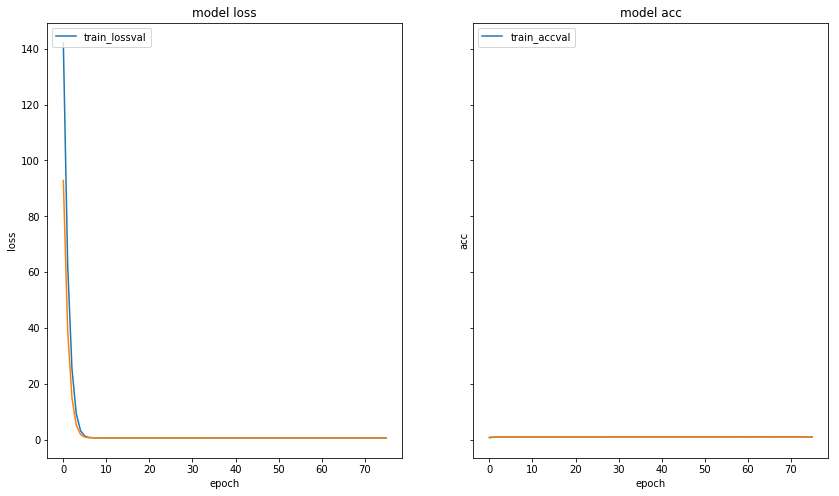

In [267]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figheight(8)
f.set_figwidth(14)

ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_title('model loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(['train_loss' 'val'], loc='upper left')

ax2.plot(history.history['acc'])
ax2.plot(history.history['val_acc'])
ax2.set_title('model acc')
ax2.set_ylabel('acc')
ax2.set_xlabel('epoch')
ax2.legend(['train_acc' 'val'], loc='upper left')

plt.show()

In [268]:
desk_net.load_weights(CHECKPOINTED_WEIGHTS)
test_data = np.load(open(TEST_FEATURES, 'r'))

In [269]:
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix
    
def kernel(x, y):
    return desk_net.predict([x, y])[:, 0]

def compute_kernel(X, Y):
    n1, n2 = X.shape[0], Y.shape[0]
    columns = [np.array([x] * n2) for x in X]    
    dot_products =[kernel(col, Y) for col in columns]
    return np.vstack(dot_products)

In [270]:
%%time
n_samples = 2000
train_examples = train_data[0: n_samples]
trainX = compute_kernel(train_examples, train_examples)

CPU times: user 2min 52s, sys: 10.7 s, total: 3min 2s
Wall time: 2min 18s


In [271]:
train_kernel = np.dot(trainX, trainX.T)

In [272]:
y_train_true = y_train[: n_samples]
C = [0.001,0.02,0.04,0.05,0.06,0.07, 0.08, 0.1, 0.2, 0.5,0.6, 0.7,0.8, 0.9, 1.0, 2.0, 5.0, 7.0, 10.0,40.0,100.0]
max_acc = 0
for slack in C: 
    clf = svm.SVC(C = slack, kernel='precomputed')
    clf.fit(train_kernel, y_train_true)
    y_train_pred = clf.predict(train_kernel)
    acc = accuracy_score(y_train_true, y_train_pred)
    if acc > max_acc:
        max_acc = acc
        best_C = slack
print(max_acc, best_C)

(0.99450000000000005, 0.04)


In [273]:
clf = svm.SVC(C = best_C, kernel='precomputed')
clf.fit(train_kernel, y_train_true)
y_train_pred = clf.predict(train_kernel)
y_train_true = y_train[: n_samples]
print(accuracy_score(y_train_true, y_train_pred))
print(confusion_matrix(y_train_true, y_train_pred))

0.9945
[[995   5]
 [  6 994]]


In [274]:
%%time
n = 2000
testX = compute_kernel(test_data[:n], train_examples)

CPU times: user 2min 49s, sys: 10.3 s, total: 2min 59s
Wall time: 2min 15s


In [275]:
test_kernel = np.dot(testX, trainX.T)
y_pred = clf.predict(test_kernel)
y_true = y_test[:n]
print(accuracy_score(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))

0.986
[[992   8]
 [ 20 980]]
